## read me

This file can process both resting state data and event related potentials. For the second, it's important that the data has event markers created with the script in the bitbrain importing section. 

Set variable **erp** to true or false to determine if you want to process event related potentials (True) or resting state data (false)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from tqdm import tqdm 
from atpbar import atpbar
from datetime import datetime
import mne
import autoreject
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

from pyprep.find_noisy_channels import NoisyChannels
from mne_icalabel import label_components


In [10]:
path = '/Users/jonasmago/PhD_code_data/github/eeg_jhana/data/mne_raw/sub7-day3-jhana-raw.fif'
raw = mne.io.read_raw(path)

Opening raw data file /Users/jonasmago/PhD_code_data/github/eeg_jhana/data/mne_raw/sub7-day3-jhana-raw.fif...
    Range : 0 ... 398495 =      0.000 ...  1556.621 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_7569/2847632005.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd()
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_7569/2847632005.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


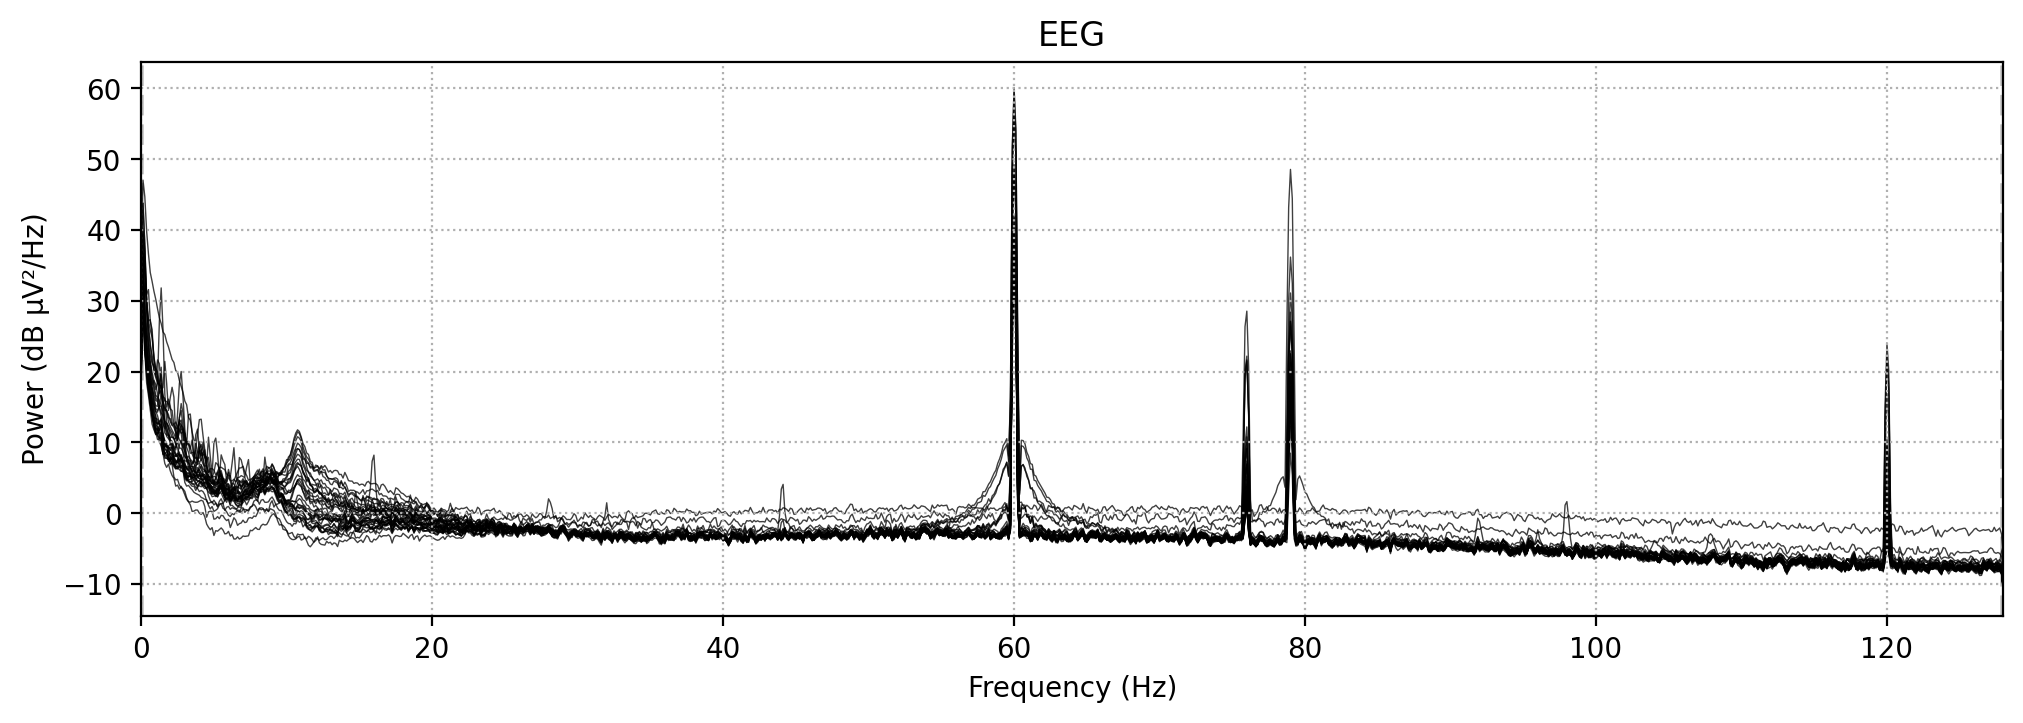

In [11]:
raw.plot_psd()

Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/data/mne_raw_events_epochs_cleaned/sub1-day1-jhana_mmn-raw_phot-events.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
350 matching events found
No baseline correction applied
0 projection items activated
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_7569/4199028585.py:2: RuntimeWarning: This filename (/Users/jonasmago/PhD_code_data/github/eeg_jhana/data/mne_raw_events_epochs_cleaned/sub1-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path)


Plotting power spectral density (dB=True).
Averaging across epochs...


/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_7569/4199028585.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.plot_psd()


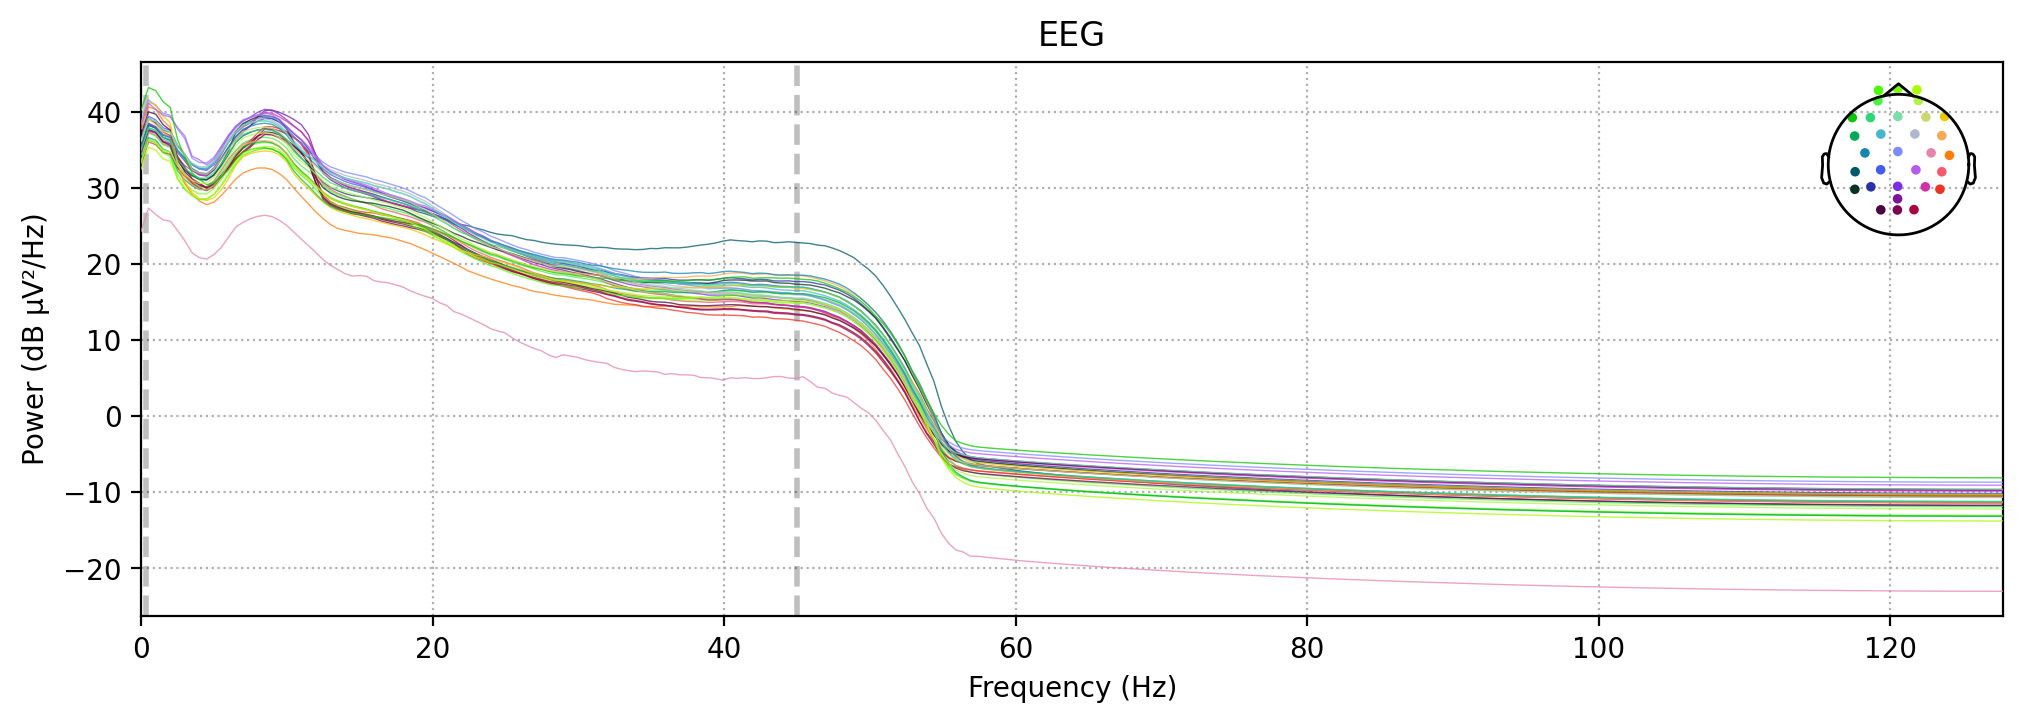

In [14]:
path = '/Users/jonasmago/PhD_code_data/github/eeg_jhana/data/mne_raw_events_epochs_cleaned/sub1-day1-jhana_mmn-raw_phot-events.fif'
epochs = mne.read_epochs(path)
epochs.plot_psd()

In [8]:
def raw_to_events(raw):
    event_id = {'-1':-1, '1':1, '-2':2, '2':2, '-3':-3, '3':3}
    events = mne.events_from_annotations(raw, event_id=event_id)[0]
    if len(events)==0:
        events = np.zeros((1,3))
        events = events.astype(int)
    return events 

In [10]:
autoreject = False

In [11]:
for erp in [True]:
    if erp == True: 
        paths = glob.glob("../../data/mne_raw_events/*")
        paths.sort()
        keywords = ["_mmn-raw_phot-events.fif"]
        paths = [path for path in paths if any(keyword in path for keyword in keywords)]
    else:
        paths = glob.glob("../../data/mne_raw/*")
        paths.sort()
        keywords = ["mmn-raw", "ltp-raw", "nimitta-raw", 'rmmn-raw', 'tetanus-raw']
        paths = [path for path in paths if not any(keyword in path for keyword in keywords)]
        paths = paths[111:]
    
    
    df = pd.DataFrame(columns=[
        'path_name',
        'bad_ch', 'bad_ch_count', 'ica_removed', 
        'ica_removed_count', 'epochs_original', 
        'epochs_remaining', 'epochs_rejected',
        'epochs_rejected_percentage'
    ])
    
    try:
        df = pd.read_csv('../../data/AR_ICA_cleaning_results.csv')
    except: 
        pass
    
    
    for path in paths:
        
        raw = mne.io.read_raw_fif(path, preload=True)
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)
        
        filt_raw = raw.copy()
        #filt_raw.filter(0.3, 45)
        filt_raw.filter(0.1, 60)
        filt_raw.notch_filter(freqs=[60,76, 120])
        filt_raw.notch_filter(freqs=84, notch_widths=1, phase='zero')
    
        if autoreject:
            nd = NoisyChannels(filt_raw, random_state=1337)
            #nd.find_bad_by_correlation()
            nd.find_bad_by_deviation()
            nd.find_bad_by_ransac()
            #bads = nd.bad_by_correlation+nd.bad_by_deviation+nd.bad_by_ransac
            bads = nd.bad_by_deviation+nd.bad_by_ransac
            filt_raw.info['bads'] = bads
    
        if erp == True:
            events = raw_to_events(raw)    
            filt_epochs = mne.Epochs(filt_raw, events, tmin=-0.5, tmax=1.5, baseline=(-0.1, 0), preload=True)
            
        else:
            filt_epochs = mne.make_fixed_length_epochs(filt_raw, duration=3, overlap=0, preload=True)

        if len (filt_epochs)<10: 
            print (f'!!!!!!! too few epochs: {path}')
            continue
            
        if autoreject: 
            filt_epochs_orig = filt_epochs.copy()
        
            ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11, n_jobs=12, verbose=False)
            ar.fit(filt_epochs)
            epochs_ar, reject_log = ar.transform(filt_epochs, return_log=True)

        else: 
            epochs_ar = filt_epochs

        """
        #filt_epochs[reject_log.bad_epochs].plot(scalings=dict(eeg=100e-6))
        #reject_log.plot('horizontal')
        
        ica = ICA(
            n_components=15,
            max_iter="auto",
            method="infomax",
            random_state=97,
            fit_params=dict(extended=True),
        )
        
        try:
            ica.fit(filt_epochs[~reject_log.bad_epochs])
        except:
            continue
        ic_labels = label_components(filt_epochs, ica, method="iclabel")
        labels = ic_labels["labels"]
        
        exclude_idx = [
            idx for idx, label in enumerate(labels) if label not in ["brain", "other"]
        ]   
            
        ica.apply(filt_epochs, exclude=exclude_idx)
        
        
        #ica.plot_sources(filt_epochs)
        #ica.plot_components()
        #ica.plot_properties(raw, picks=[0, 12], verbose=False)
        #filt_epochs_orig.plot()
        #filt_epochs.plot()
        
        ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11, n_jobs=1, verbose=True)
        ar.fit(filt_epochs)
        epochs_ar_2, reject_log_2 = ar.transform(filt_epochs, return_log=True)
        
        #filt_epochs[reject_log.bad_epochs].plot(scalings=dict(eeg=100e-6))
        #reject_log2.plot('horizontal')
    
        print ("##############")
        print (path)
        
        print (f"bad channels: {bads}")
        for i in ic_labels["labels"]:
            print (i)
        print(f"Excluding these ICA components: {exclude_idx}")
        print(f"remaining epochs: {len(epochs_ar_2)}")
        
        plotting = False
        if plotting == True:
            ica.plot_components()
    
            reject_log.plot('horizontal')
            reject_log_2.plot('horizontal')
    
            filt_epochs_orig.plot(title="original")
            filt_epochs.plot(title="filt_epochs")
            epochs_ar_2.plot(title="epochs_ar_2")
    
            #epochs_ar_2.drop_log
    
        """
        #SAVING
        basename = os.path.basename(path)
        folder = os.path.dirname(path)
        output_fname = f"{folder}_epochs_cleaned_noICA_noAutoreject/{basename}"
        epochs_ar.save(output_fname, overwrite=True)
        
        """
        # save df
       
        bad_ch = str(bads)
        bad_ch_count = len(bads)
        ica_removed = str(exclude_idx)
        ica_removed_count = len(exclude_idx)
        epochs_original = len(filt_epochs_orig)
        epochs_remaining = len(epochs_ar_2)
        epochs_rejected = len(filt_epochs_orig) - len(epochs_ar_2)
        epochs_rejected_percentage = np.round((1-(epochs_remaining/epochs_original)),2)
        
        # Create a new DataFrame for this iteration
        new_row = pd.DataFrame({
            'path_name': [os.path.basename(path)],
            'bad_ch': [bad_ch], 'bad_ch_count': [bad_ch_count], 'ica_removed': [ica_removed],
            'ica_removed_count': [ica_removed_count], 'epochs_original': [epochs_original],
            'epochs_remaining': [epochs_remaining], 'epochs_rejected': [epochs_rejected], 
            'epochs_rejected_percentage': [epochs_rejected_percentage]
        })
        
        df = pd.concat([df, new_row], ignore_index=True)
    
        df.to_csv('../../data/AR_ICA_cleaning_results.csv', index=False)
        """
    


Opening raw data file ../../data/mne_raw_events/sub0-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 768 ... 188247 =      3.000 ...   735.340 secs
Ready.
Reading 0 ... 187479  =      0.000 ...   732.340 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)



/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub0-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
320 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 320 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub0-day1-jhana_mmn-raw_phot-events.fif...
    Range : 512 ... 219903 =      2.000 ...   858.996 secs
Ready.
Reading 0 ... 219391  =      0.000 ...   856.996 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub0-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub0-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub0-day1-mindfulness_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub0-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub0-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 256 ... 216663 =      1.000 ...   846.340 secs
Ready.
Reading 0 ... 216407  =      0.000 ...   845.340 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub0-day2-jhana_mmn-raw_phot-events.fif...
    Range : 512 ... 216903 =      2.000 ...   847.277 secs
Ready.
Reading 0 ... 21639

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub0-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub0-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub0-day2-mindfulness_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub0-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub0-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 0 ... 215823 =      0.000 ...   843.059 secs
Ready.
Reading 0 ... 215823  =      0.000 ...   843.059 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub0-day3-jhana_mmn-raw_phot-events.fif...
    Range : 256 ... 217199 =      1.000 ...   848.434 secs
Ready.
Reading 0 ... 21694

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub0-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub0-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub0-day3-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 219567 =      1.000 ...   857.684 secs
Ready.
Reading 0 ... 219311  =      0.000 ...   856.684 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub0-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub0-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub0-day4-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 225967 =      0.000 ...   882.684 secs
Ready.
Reading 0 ... 225967  =      0.000 ...   882.684 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub0-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub0-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub0-day4-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 224911 =      0.000 ...   878.559 secs
Ready.
Reading 0 ... 224911  =      0.000 ...   878.559 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub0-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub0-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub1-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 512 ... 217351 =      2.000 ...   849.027 secs
Ready.
Reading 0 ... 216839  =      0.000 ...   847.027 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub0-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub1-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub1-day1-jhana_mmn-raw_phot-events.fif...
    Range : 256 ... 219967 =      1.000 ...   859.246 secs
Ready.
Reading 0 ... 219711  =      0.000 ...   858.246 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub1-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub1-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub1-day1-mindfulness_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub1-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub1-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 256 ... 216663 =      1.000 ...   846.340 secs
Ready.
Reading 0 ... 216407  =      0.000 ...   845.340 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub1-day2-jhana_mmn-raw_phot-events.fif...
    Range : 256 ... 216831 =      1.000 ...   846.996 secs
Ready.
Reading 0 ... 21657

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub1-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub1-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub1-day2-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 217543 =      1.000 ...   849.777 secs
Ready.
Reading 0 ...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub1-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub1-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub1-day3-jhana_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub1-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub1-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 0 ... 216775 =      0.000 ...   846.777 secs
Ready.
Reading 0 ... 216775  =      0.000 ...   846.777 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub1-day3-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 219303 =      1.000 ...   856.652 secs
Ready.
Reading 0 ...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub1-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub1-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub1-day4-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 225743 =      0.000 ...   881.809 secs
Ready.
Reading 0 ... 225743 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub1-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub1-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub1-day4-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 226159 =      0.000 ...   883.434 secs
Ready.
Reading 0 ... 226159  =      0.000 ...   883.434 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub1-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub1-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub10-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 219503 =      1.000 ...   857.434 secs
Ready.
Reading 0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub1-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub10-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub11-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 220143 =      1.000 ...   859.934 secs
Ready.
Reading 0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub10-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub11-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub12-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 512 ... 219967 =      2.000 ...   859.246 secs
Ready.
Reading 0 ... 219455  =      0.000 ...   857.246 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub11-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub12-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub2-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 216975 =      1.000 ...   847.559 secs
Ready.
Reading 0 ... 216719  =      0.000 ...   846.559 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub12-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub2-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub2-day1-jhana_mmn-raw_phot-events.fif...
    Range : 256 ... 217191 =      1.000 ...   848.402 secs
Ready.
Reading 0 ... 216935  =      0.000 ...   847.402 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub2-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub2-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub2-day1-mindfulness_mmn-raw_phot-events.fif...
    Range : 512 ... 217935 =      2.000 ...   851.309 secs
Ready.
Reading 0 ...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub2-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub2-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub2-day2-jhana_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub2-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub2-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 512 ... 218511 =      2.000 ...   853.559 secs
Ready.
Reading 0 ... 217999  =      0.000 ...   851.559 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub2-day2-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 221023 =      1.000 ...   863.371 secs
Ready.
Reading 0 ...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub2-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub2-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['1']
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 513 original time points ...
0 bad epochs dropped
!!!!!!! too few epochs: ../../data/mne_raw_events/sub2-day2-mindfulness_mmn-raw_phot-events.fif
Opening raw data file ../../data/mne_raw_events/sub2-day3-jhana_mmn-raw_phot-events.fif...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub2-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub2-day3-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 220959 =      0.000 ...   863.121 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub2-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub2-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub2-day4-jhana_mmn-raw_phot-events.fif...
    Range : 512 ... 220591 =      2.000 ...   861.684 secs
Ready.
Reading 0 ... 22007

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub2-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub2-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub2-day4-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 225719 =      0.000 ...   881.715 secs
Ready.
Reading 0 ... 225719  =      0.000 ...   881.715 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub2-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub2-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub3-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 218215 =      1.000 ...   852.402 secs
Ready.
Reading 0 ... 217959  =      0.000 ...   851.402 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub2-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub3-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub3-day1-jhana_mmn-raw_phot-events.fif...
    Range : 768 ... 216951 =      3.000 ...   847.465 secs
Ready.
Reading 0 ... 216183  =      0.000 ...   844.465 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub3-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub3-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub3-day1-mindfulness_mmn-raw_phot-events.fif...
    Range : 512 ... 217487 =      2.000 ...   849.559 secs
Ready.
Reading 0 ...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub3-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub3-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub3-day2-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 217343 =      0.000 ...   848.996 secs
Ready.
Reading 0 ... 217343  =      0.000 ...   848.996 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub3-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub3-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub3-day2-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 221303 =      1.000 ...   864.465 secs
Ready.
Reading 0 ... 221047  =      0.000 ...   863.465 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub3-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub3-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['1']
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 513 original time points ...
0 bad epochs dropped
!!!!!!! too few epochs: ../../data/mne_raw_events/sub3-day2-mindfulness_mmn-raw_phot-events.fif
Opening raw data file ../../data/mne_raw_events/sub3-day3-jhana_mmn-raw_phot-events.fif...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub3-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub3-day3-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 217615 =      0.000 ...   850.059 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub3-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub3-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub3-day4-jhana_mmn-raw_phot-events.fif...
Isotrak not found
    Range : 0 ... 222447 =      0.000 ...   868.934 secs
Ready.
Rea

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub3-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub3-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub3-day4-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 223151 =      0.000 ...   871.684 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub3-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub3-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub4-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 512 ... 218231 =      2.000 ...   852.465 secs
Ready.
Reading 0 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub3-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub4-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub4-day1-jhana_mmn-raw_phot-events.fif...
    Range : 256 ... 218567 =      1.000 ...   853.777 secs
Ready.
Reading 0 ... 21831

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub4-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub4-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub4-day1-mindfulness_mmn-raw_phot-events.fif...
    Range : 512 ... 218943 =      2.000 ...   855.246 secs
Ready.
Reading 0 ... 218431  =      0.000 ...   853.246 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub4-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub4-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub4-day2-jhana_mmn-raw_phot-events.fif...
    Range : 256 ... 216855 =      1.000 ...   847.090 secs
Ready.
Reading 0 ... 216599  =      0.000 ...   846.090 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub4-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub4-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub4-day2-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 218663 =      0.000 ...   854.152 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub4-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub4-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub4-day3-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 233911 =      0.000 ...   913.715 secs
Ready.
Reading 0 ... 233911  =      0.000 ...   913.715 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub4-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub4-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub4-day3-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 215159 =      0.000 ...   840.465 secs
Ready.
Reading 0 ... 215159  =      0.000 ...   840.465 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub4-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub4-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
368 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 368 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub4-day4-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 216575 =      0.000 ...   845.996 secs
Ready.
Reading 0 ... 216575  =      0.000 ...   845.996 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub4-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub4-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub4-day4-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 222063 =      1.000 ...   867.434 secs
Ready.
Reading 0 ...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub4-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub4-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub5-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 218783 =      1.000 ...   854.621 secs
Ready.
Reading 0 ... 218527  =      0.000 ...   853.621 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub4-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub5-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub5-day1-jhana_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub5-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub5-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 1024 ... 218375 =      4.000 ...   853.027 secs
Ready.
Reading 0 ... 217351  =      0.000 ...   849.027 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub5-day1-mindfulness_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub5-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub5-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 768 ... 217383 =      3.000 ...   849.152 secs
Ready.
Reading 0 ... 216615  =      0.000 ...   846.152 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub5-day2-jhana_mmn-raw_phot-events.fif...
    Range : 256 ... 216599 =      1.000 ...   846.090 secs
Ready.
Reading 0 ... 21634

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub5-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub5-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub5-day2-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 216623 =      0.000 ...   846.184 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub5-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub5-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub5-day3-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 232335 =      0.000 ...   907.559 secs
Ready.
Reading 0 ... 232335  =      0.000 ...   907.559 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Fil

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub5-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub5-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub5-day3-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 215855 =      0.000 ...   843.184 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub5-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub5-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub5-day4-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 214575 =      0.000 ...   838.184 secs
Ready.
Reading 0 ... 214575  =      0.000 ...   838.184 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub5-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub5-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
369 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 369 events and 513 original time points ...
1 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub5-day4-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 219927 =      1.000 ...   859.090 secs
Ready.
Reading 0 ... 219671  =      0.000 ...   858.090 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub5-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub5-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub6-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 217959 =      1.000 ...   851.402 secs
Ready.
Reading 0 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub5-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub6-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub6-day1-jhana_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub6-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub6-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 512 ... 218503 =      2.000 ...   853.527 secs
Ready.
Reading 0 ... 217991  =      0.000 ...   851.527 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub6-day1-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 217663 =      0.000 ...   850.246 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub6-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub6-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub6-day2-jhana_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub6-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub6-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 256 ... 216807 =      1.000 ...   846.902 secs
Ready.
Reading 0 ... 216551  =      0.000 ...   845.902 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub6-day2-mindfulness_mmn-raw_phot-events.fif...
    Range : 512 ... 215359 =      2.000 ...   841.246 secs
Ready.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub6-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub6-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Reading 0 ... 214847  =      0.000 ...   839.246 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
368 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 368 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub6-day3-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 215575 =      0.000 ...   842.090 secs
Ready.
Reading 0 ... 215575 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub6-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub6-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub6-day3-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 219735 =      0.000 ...   858.340 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub6-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub6-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub6-day4-jhana_mmn-raw_phot-events.fif...
    Range : 7936 ... 223007 =     31.000 ...   871.121 secs
Ready.
Reading 0 ... 215071  =      0.000 ...   840.121 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub6-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub6-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
367 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 367 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub6-day4-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 221831 =      0.000 ...   866.527 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub6-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub6-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
293 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 293 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub7-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 768 ... 220471 =      3.000 ...   861.215 secs
Ready.
Reading 0 ... 219703  =      0.000 ...   858.215 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub6-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub7-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub7-day1-jhana_mmn-raw_phot-events.fif...
    Range : 512 ... 217871 =      2.000 ...   851.059 secs
Ready.
Reading 0 ... 21735

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub7-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub7-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub7-day1-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 215839 =      0.000 ...   843.121 secs
Ready.
Reading 0 ... 215839  =      0.000 ...   843.121 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub7-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub7-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub7-day2-jhana_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub7-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)


    Range : 0 ... 217927 =      0.000 ...   851.277 secs
Ready.
Reading 0 ... 217927  =      0.000 ...   851.277 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)



/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub7-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub7-day2-mindfulness_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub7-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub7-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 256 ... 214719 =      1.000 ...   838.746 secs
Ready.
Reading 0 ... 214463  =      0.000 ...   837.746 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub7-day3-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 215743 =      0.000 ...   842.746 secs
Ready.
Reading 0 ... 215743 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub7-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub7-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
368 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 368 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub7-day3-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 219943 =      0.000 ...   859.152 secs
Ready.
Reading 0 ... 219943  =      0.000 ...   859.152 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub7-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub7-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub7-day4-jhana_mmn-raw_phot-events.fif...
    Range : 256 ... 222623 =      1.000 ...   869.621 secs
Ready.
Reading 0 ... 222367  =      0.000 ...   868.621 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub7-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub7-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
368 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 368 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub7-day4-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 220959 =      0.000 ...   863.121 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub7-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub7-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 50 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub8-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 256 ... 219103 =      1.000 ...   855.871 secs
Ready.
Reading 0 ..

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub7-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub8-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub8-day1-jhana_mmn-raw_phot-events.fif...
    Range : 512 ... 221399 =      2.000 ...   864.840 secs
Ready.
Reading 0 ... 22088

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub8-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub8-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub8-day1-mindfulness_mmn-raw_phot-events.fif...
    Range : 512 ... 217775 =      2.000 ...   850.684 secs
Ready.
Reading 0 ...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub8-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub8-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub8-day2-jhana_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub8-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub8-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 256 ... 213703 =      1.000 ...   834.777 secs
Ready.
Reading 0 ... 213447  =      0.000 ...   833.777 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
368 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 368 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub8-day2-mindfulness_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub8-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub8-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 512 ... 216271 =      2.000 ...   844.809 secs
Ready.
Reading 0 ... 215759  =      0.000 ...   842.809 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub8-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)


Opening raw data file ../../data/mne_raw_events/sub8-day3-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 218679 =      0.000 ...   854.215 secs
Ready.
Reading 0 ... 218679  =      0.000 ...   854.215 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)



/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub8-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub8-day3-mindfulness_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub8-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub8-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 0 ... 215535 =      0.000 ...   841.934 secs
Ready.
Reading 0 ... 215535  =      0.000 ...   841.934 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
368 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 368 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub8-day4-jhana_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub8-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub8-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 256 ... 227039 =      1.000 ...   886.871 secs
Ready.
Reading 0 ... 226783  =      0.000 ...   885.871 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower tran

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub8-day4-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 221231 =      0.000 ...   864.184 secs
Ready.
Reading 0 ... 2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub8-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub8-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub9-control-mindfulness_mmn-raw_phot-events.fif...
    Range : 512 ... 220175 =      2.000 ...   860.059 secs
Ready.
Reading 0 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub8-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub9-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub9-day1-jhana_mmn-raw_phot-events.fif...
    Range : 512 ... 220927 =      2.000 ...   862.996 secs
Ready.
Reading 0 ... 22041

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub9-control-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub9-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub9-day1-mindfulness_mmn-raw_phot-events.fif...
    Range : 512 ... 217199 =      2.000 ...   848.434 secs
Ready.
Reading 0 ... 216687  =      0.000 ...   846.434 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub9-day1-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub9-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub9-day2-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 213639 =      0.000 ...   834.527 secs
Ready.
Reading 0 ... 213639  =      0.000 ...   834.527 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub9-day1-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub9-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub9-day2-mindfulness_mmn-raw_phot-events.fif...
    Range : 1024 ... 215271 =      4.000 ...   840.902 secs
Ready.
Reading 0 ... 214247  =      0.000 ...   836.902 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub9-day2-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub9-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
369 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 369 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub9-day3-jhana_mmn-raw_phot-events.fif...
    Range : 0 ... 218239 =      0.000 ...   852.496 secs
Ready.
Reading 0 ... 218239 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub9-day2-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub9-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub9-day3-mindfulness_mmn-raw_phot-events.fif...
    Range : 0 ... 215151 =      0.000 ...   840.434 secs
Ready.
Reading 0 ... 215151  =      0.000 ...   840.434 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub9-day3-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub9-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
367 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 367 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub9-day4-jhana_mmn-raw_phot-events.fif...
    Range : 512 ... 224727 =      2.000 ...   877.840 secs
Ready.
Reading 0 ... 22421

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub9-day3-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub9-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
368 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 368 events and 513 original time points ...
0 bad epochs dropped
Opening raw data file ../../data/mne_raw_events/sub9-day4-mindfulness_mmn-raw_phot-events.fif...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub9-day4-jhana_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:31: RuntimeWarning: This filename (../../data/mne_raw_events/sub9-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 0 ... 219391 =      0.000 ...   856.996 secs
Ready.
Reading 0 ... 219391  =      0.000 ...   856.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 83 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 82.75 Hz)
- Upper passband edge: 85.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 85.25 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: ['-1', '1']
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 370 events and 513 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_82535/3362594293.py:137: RuntimeWarning: This filename (../../data/mne_raw_events_epochs_cleaned_noICA_noAutoreject/sub9-day4-mindfulness_mmn-raw_phot-events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_ar.save(output_fname, overwrite=True)
